# Java Development Tool Bug Classification

In [121]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

tqdm.pandas()
sns.set()
pd.set_option('display.max_colwidth', 50)

BASE_PATH = Path("../DATASETS/java-bug/")

In [105]:
df = pd.read_csv(BASE_PATH/'eclipse_jdt.csv.gz')

### Analysing

In [106]:
df.head(2)

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time
0,1518,P1,Debug,NaN,Icons needed for actions (1GI5UXW),JGS (8/8/01 5:20:19 PM); \tWe need enabled; di...,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2001-10-18 11:51:14 -0400
1,1519,P3,Debug,NaN,README: Hit count not reset (1GET20Y),JGS (6/4/01 11:43:47 AM); \tSet a breakpoint i...,RESOLVED,WORKSFORME,2.0,2001-10-10 22:14:00 -0400,2001-11-28 13:42:46 -0500


In [107]:
df.isna().sum() 

Issue_id                0
Priority                0
Component               0
Duplicated_issue    37608
Title                   0
Description            43
Status                  0
Resolution              0
Version                 0
Created_time            0
Resolved_time           0
dtype: int64

In [108]:
print("Length of the dataset: ", len(df))

Length of the dataset:  45296


In [109]:
print(f"So, we've {len(df) - 37608} duplicate issues")

So, we've 7688 duplicate issues


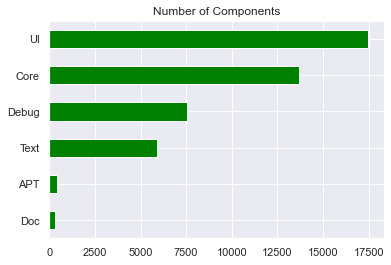

In [110]:
ax = df['Component'].value_counts().plot.barh(title = 'Number of Components', color = 'green')
ax.invert_yaxis()

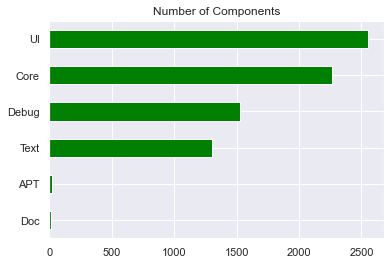

In [111]:
# just check value count of duplicate issues

duplicate = df[~df['Duplicated_issue'].isna()]['Component']
duplicate.value_counts().plot.barh(title = 'Number of Components', color = 'green').invert_yaxis()

In [112]:
df.iloc[duplicate.index[0]].T

Issue_id                                                         1522
Priority                                                           P2
Component                                                       Debug
Duplicated_issue                                               1663.0
Title               Feature: use #toString to display variable val...
Description         DW (9/27/00 11:12:31 AM); \tCurrently; the typ...
Status                                                       RESOLVED
Resolution                                                  DUPLICATE
Version                                                           2.0
Created_time                                2001-10-10 22:14:00 -0400
Resolved_time                               2001-10-17 10:17:47 -0400
Name: 4, dtype: object

In [113]:
df.iloc[1663].T

Issue_id                                                         5357
Priority                                                           P3
Component                                                       Debug
Duplicated_issue                                                  NaN
Title                   Feature: Action to select line for evaluation
Description         To simplify the execution of the recently ente...
Status                                                       RESOLVED
Resolution                                                    WONTFIX
Version                                                           2.0
Created_time                                2001-10-30 11:04:00 -0500
Resolved_time                               2002-07-15 16:07:14 -0400
Name: 1663, dtype: object

### Data Preparation

In [114]:
import html
import re

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [115]:
df = df[['Title', 'Description', 'Component']]
df.dropna(inplace=True)
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])

In [116]:
df.columns

Index(['Component', 'text'], dtype='object')

In [117]:
df['text'] = df['text'].progress_apply(clean)

100%|██████████████████████████████████████████████████| 45253/45253 [00:13<00:00, 3360.05it/s]


In [120]:
df = df[df['text'].str.len() > 50]
df.sample(4)

,Component,text
13614,Text,Out of memory using comment feature Trying to ...
3741,UI,Externalize Strings of compilation unit fails ...
23607,UI,Move Refactoring has inconsistent preview UI r...
19222,UI,bad idea to subclass Error for ordinary except...


### Train Test

In [132]:
from sklearn.model_selection import train_test_split

In [133]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                                df['text'],
                                                df['Component'],
                                                test_size=.2,
                                                stratify=df['Component'],
                                                random_state=42
                                            )

In [135]:
print("Size of Training Data: ", X_train.shape[0])
print("Size of Testing Data: ", X_test.shape[0])

Size of Training Data:  36040
Size of Testing Data:  9011
